In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/fashion-mnist-itba/submission_sample.csv
/kaggle/input/fashion-mnist-itba/fashion-mnist-itba-lab-ml-2018b.zip


In [2]:
import zipfile
path_to_zip_file = '/kaggle/input/fashion-mnist-itba/fashion-mnist-itba-lab-ml-2018b.zip'
zipfile.ZipFile(path_to_zip_file, 'r').extractall('/kaggle/working/data')


In [3]:
X_train = np.load('/kaggle/working/data/train_images.npy')
X_test = np.load('/kaggle/working/data/test_images.npy')
y_train = pd.read_csv('/kaggle/working/data/train_labels.csv')['label'].values

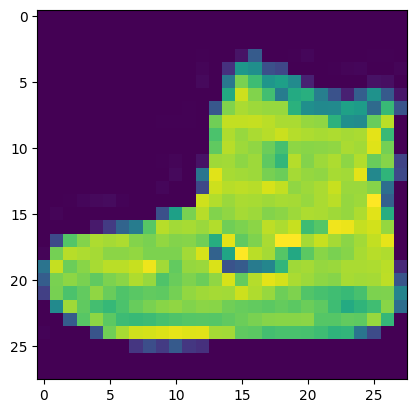

In [4]:
import matplotlib.pyplot as plt
plt.imshow(X_train[0])

In [5]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn as nn

In [6]:
images_x = torch.tensor(X_train, dtype = torch.float32).unsqueeze(1) / 255
images_y = torch.tensor(y_train, dtype = torch.float32)
images_y = images_y.type(torch.LongTensor)
device = torch.device('cuda')
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 20, 3, padding=1),
            nn.ReLU()
        )
        self.flatten = nn.Flatten()
        self.edges1 = nn.Linear(28 * 28 * 20, 64)
        self.edges2 = nn.Linear(64, 10)
        self.activation = nn.Sigmoid()
    def forward(self, x):
        x = self.conv(x)
        x = self.flatten(x)
        x = self.edges1(x)
        x = self.activation(x)
        x = self.edges2(x)
        return x
class ComfortableData(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y
    def __getitem__(self, idd):
        return self.x[idd], self.y[idd]
    def __len__(self):
        return len(self.x)
comfort_data = ComfortableData(images_x, images_y)
data_for_train = DataLoader(comfort_data, batch_size = 128, shuffle = True)
model = CNN().to(device)
cr = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.01)
epochs = 11
corrects = 0
for i in range(epochs):
    cost = 0
    for image, answer in data_for_train:
        image = image.to(device)
        answer = answer.to(device)
        optimizer.zero_grad()
        predictions = model(image)
        error = cr(predictions, answer)
        error.backward()
        optimizer.step()
        cost += error.item()
        if i == epochs - 1:
            for j in range(len(answer)):
                # print(torch.argmax(predictions[j]).item(), answer[j].item())
                if torch.argmax(predictions[j]).item() == answer[j].item():
                    corrects += 1
            # if counter < 1:
            #     for j in range(len(answer)):
            #         print(torch.argmax(predictions[j]).item())
            #         img = image[j].view(28, 28)
            #         plt.imshow(img, cmap='Blues')
            #         plt.show()
            #         counter += 1
    
    if i % 1 == 0:
        print(cost/len(data_for_train))
print("accuracy:", corrects, len(data_for_train)*128, corrects / (len(data_for_train)*128))


0.5589994293476727
0.30207887018667356
0.2532713531272244
0.21874826344282133
0.1830083479219154
0.15582012578146034
0.13426188115419738
0.11562479210338358
0.09781592247137891
0.08375994066820978
0.07473699160730407
accuracy: 58413 60032 0.9730310501066098


In [7]:
images_x = torch.tensor(X_test, dtype = torch.float32).unsqueeze(1) / 255
images_y = []
for y in range(len(X_test)):
    images_y.append(y)
images_y = torch.tensor(images_y, dtype = torch.float32)
images_y = images_y.type(torch.LongTensor)
comfort_data = ComfortableData(images_x, images_y)
data_for_test = DataLoader(comfort_data, batch_size = 128, shuffle=True)

corrects = 0
ans = []
for y in range(len(X_test)):
    ans.append(0)
for image, answer in data_for_test:
    optimizer.zero_grad()
    predictions = model(image.to(device))
    for j in range(len(answer)):
        ans[answer[j].item()] = (torch.argmax(predictions[j]).item())
sub = pd.read_csv('/kaggle/input/fashion-mnist-itba/submission_sample.csv')
sub['Category'] = ans
sub.to_csv('submission.csv', index=False)
